In [1]:
import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
from keras.models import Sequential, model_from_json, load_model
from keras.layers.core import Dense, Dropout, Flatten, Activation, SpatialDropout2D, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU, PReLU, LeakyReLU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Convolution1D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from scipy.io import wavfile
import pdb
import scipy.io
import librosa
import os
from os.path import join as ojoin
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

import time  
import numpy as np
import numpy.matlib
import argparse
import random
import theano
# os.environ['KERAS_BACKEND'] = 'theano'
# import theano.tensor as T
import tensorflow as tf
from keras.callbacks import TensorBoard
import keras.backend.tensorflow_backend as KTF
# from keras.utils import to_categorical,plot_model
from ipykernel import kernelapp as app

tf.reset_default_graph()


Using TensorFlow backend.
C:\Users\hsiaoen\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hsiaoen\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hsiaoen\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hsiaoen\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
KTF.set_session(session)
random.seed(999)

GPU found


In [3]:
def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.

    for root, directories, files in os.walk(directory):

        for filename in files:
            if filename.endswith('.wav'):
            # Join the two strings in order to form the full filepath.
                filepath = os.path.join(root, filename)
                file_paths.append(filepath)  # Add it to the list.
                # pdb.set_trace()

    return file_paths  # Self-explanatory.
mixed_file=get_filepaths('mixed_pos_snr')
cleaned_file=get_filepaths('clean')
pos=get_filepaths('mixed_pos_snr')

In [4]:
#整理檔案路徑排序
#確認乾淨的答案有對應到混音完的檔案
clean_files=[]
for i in mixed_file:
    clean_file='_'.join(i.split('\\')[1].split('_')[:3])+'.wav'
    for j in cleaned_file:
#         print(j)
        if clean_file == j.split('\\')[-1]:
            clean_files.append(j)
        

In [5]:
clean_files[:10]

['clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav']

In [ ]:
##切分train-test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mixed_file,clean_files,test_size=0.33, random_state=42)    
Train_Noisy_lists=X_train
Train_Clean_paths= y_train

Test_Noisy_lists  = X_test
Test_Clean_paths = y_test
          
Num_testdata=len(Test_Noisy_lists)   
Num_traindata=len(Train_Noisy_lists)

In [ ]:
def train_data_generator(noisy_list, clean_path):
    index=0
    while True:
        noisy, rate  = librosa.load(noisy_list[index],sr=16000) 
        # print(noisy_list[index],index)
        # pdb.set_trace()

        D=librosa.stft(noisy,n_fft=512,hop_length=256,win_length=512,center=False)
        noisy = np.abs(D)
        #轉向因為高固定 但長度不同
        noisy = noisy.T
        noisy=np.reshape(noisy,(1,np.shape(noisy)[0],np.shape(noisy)[1]))
        noisy_shi=np.angle(D)


        clean, rate  =librosa.load(clean_path[index],sr=16000) 
        D=librosa.stft(clean,n_fft=512,hop_length=256,win_length=512,center=False)
        clean = np.abs(D)
        #轉向因為高固定 但長度不同
        clean = clean.T
        clean=np.reshape(clean,(1,np.shape(clean)[0],np.shape(clean)[1]))
        clean_shi=np.angle(D)

        index += 1
        if index == len(noisy_list):
            index = 0

        yield noisy, clean

def val_data_generator(noisy_list, clean_path):
    index=0
    while True:
        noisy, rate  = librosa.load(noisy_list[index],sr=16000)       
        D=librosa.stft(noisy,n_fft=512,hop_length=256,win_length=512,center=False)
        noisy = np.abs(D)
        #轉向因為高固定 但長度不同
        noisy = noisy.T
        noisy=np.reshape(noisy,(1,np.shape(noisy)[0],np.shape(noisy)[1]))
        noisy_shi=np.angle(D)
          
        clean, rate  =librosa.load(clean_path[index],sr=16000) 
        D=librosa.stft(clean,n_fft=512,hop_length=256,win_length=512,center=False)
        clean = np.abs(D)
        #轉向因為高固定 但長度不同
        clean = clean.T
        clean=np.reshape(clean,(1,np.shape(clean)[0],np.shape(clean)[1]))
        clean_shi=np.angle(D)


        index += 1
        if index == len(noisy_list):
            index = 0
          
        yield noisy, clean 

In [7]:
start_time = time.time()

print('model building...')

model = Sequential()


model.add(Conv1D(60, 55, padding='same', input_shape=(None,257)))
model.add(BatchNormalization(axis=-1))
model.add(LeakyReLU())
model.add(Dropout(0.06))

model.add(Conv1D(80, 55,  padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(LeakyReLU())
model.add(Dropout(0.06))

model.add(Conv1D(80, 55,  padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(LeakyReLU())
model.add(Dropout(0.06))

model.add(Conv1D(100, 55,  padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(LeakyReLU())
model.add(Dropout(0.06))

model.add(Conv1D(100, 55,  padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(LeakyReLU())
model.add(Dropout(0.06))

model.add(Conv1D(120, 55,  padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(LeakyReLU())
model.add(Dropout(0.06))

model.add(Conv1D(257, 55,  padding='same'))
# model.add(Activation('tanh'))
model.add(LeakyReLU())


# model.load_weights('firsttry')
model.summary()

#sgd = SGD(lr=0.001, decay=5*1e-8, momentum=0.9, nesterov=True)
# plot_model(model,show_shapes = True)

model building...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 60)          848160    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 60)          240       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, 60)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 60)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 80)          264080    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 80)          320       
_____

In [9]:
epoch=5
batch_size=1
# Adam=tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
    
with open('{}.json'.format('firsttry'),'w') as f:    # save the model
    f.write(model.to_json()) 
checkpointer = ModelCheckpoint(filepath='{}.hdf5'.format('firsttry'), verbose=1, save_best_only=True, mode='min')  

print ('training...')

g1 = train_data_generator(Train_Noisy_lists, Train_Clean_paths)
g2 = val_data_generator(Test_Noisy_lists, Test_Clean_paths)

tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)
hist=model.fit_generator(g1,
                         samples_per_epoch=Num_traindata,
                        # samples_per_epoch=50, 
                         nb_epoch=epoch, 
                         verbose=1,
                         validation_data=g2,
                         nb_val_samples=Num_testdata,
                         max_q_size=1, 
                         nb_worker=1,
                         pickle_safe=False,
                         )                          


training...


C:\Users\hsiaoen\venv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\hsiaoen\venv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, validation_data=<generator..., steps_per_epoch=45024, epochs=5, validation_steps=22176, workers=1, use_multiprocessing=False, max_queue_size=1)`



Epoch 1/5
45024/45024 [==============================] - 1420s 32ms/step - loss: 0.0302 - val_loss: 0.0274
Epoch 2/5
45024/45024 [==============================] - 1622s 36ms/step - loss: 0.0224 - val_loss: 0.0295
Epoch 3/5
45024/45024 [==============================] - 1366s 30ms/step - loss: 0.0198 - val_loss: 0.0280
Epoch 4/5
45024/45024 [==============================] - 1369s 30ms/step - loss: 0.0182 - val_loss: 0.0276
Epoch 5/5
45024/45024 [==============================] - 1372s 30ms/step - loss: 0.0170 - val_loss: 0.0254


In [11]:
#存h5檔
sav=model.save('mixed_all_snr_raw_1dx9_15epoch.h5')
sav

In [12]:
## 畫Loss圖

# # plotting the learning curve
TrainERR=hist.history['loss']
ValidERR=hist.history['val_loss']
print ('@%f, Minimun error:%f, at iteration: %i' % (hist.history['val_loss'][epoch-1], np.min(np.asarray(ValidERR)),np.argmin(np.asarray(ValidERR))+1))
# print 'drawing the training process...'
plt.clf()
plt.figure(4)
plt.plot(range(1,epoch+1),TrainERR,'b',label='TrainERR')
plt.plot(range(1,epoch+1),ValidERR,'r',label='ValidERR')
plt.xlim([1,epoch])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('error')
plt.grid(True)
plt.show()
plt.savefig('Learning_curve_{sav}.png', dpi=150)


end_time = time.time()
print ('The code for this file ran for %.2fm' % ((end_time - start_time) / 60.))


@0.025445, Minimun error:0.025445, at iteration: 5
The code for this file ran for 120.30m


C:\Users\hsiaoen\venv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [13]:
tf.reset_default_graph()

In [10]:
maxv = np.iinfo(np.int16).max 
for path in Test_Noisy_lists[:10]: # Ex: /mnt/hd-02/avse/testing/noisy/engine/1dB/1.wav
    S=path.split('\\') 
    # noise=S[-3]
    # dB=S[-2]
    wave_name=S[1]
    noisy, rate  = librosa.load(path,sr=16000) 
    noisy=noisy.astype('float32')
    # print(noisy_list[index],index)
    # pdb.set_trace()
    D=librosa.stft(noisy,n_fft=512,hop_length=256,win_length=512,center=False)
    noisy = np.abs(D)
    #轉向因為高固定 但長度不同
    noisy = noisy.T
    print(noisy.shape)
    noisy_shi=np.angle(D)

    noisy=np.reshape(noisy,(1,np.shape(noisy)[0],np.shape(noisy)[1]))
#     print('reshape====>',noisy.shape)
    enhanced=np.squeeze( model.predict(noisy, batch_size=1)).T
#     print(enhanced.shape)
    Rec = np.multiply(enhanced, np.exp(1j * noisy_shi))
    enhanced=librosa.istft(Rec,hop_length=256,win_length=512,center=False)
#     enhanced=enhanced/np.max(abs(enhanced))
    enhanced=enhanced* maxv
    enhanced_2=enhanced.astype('int16')
#     enhanced=enhanced/2**15
    wavfile.write(os.path.join("c:\\test", wave_name),16000,(enhanced).astype(np.int16))

(212, 257)
(188, 257)
(164, 257)
(213, 257)
(170, 257)
(175, 257)
(233, 257)
(208, 257)
(195, 257)
(177, 257)


### 播放

In [ ]:
model = tf.contrib.keras.models.load_model('mixed_pos_snr_raw_1dx7_10epoch.h5')

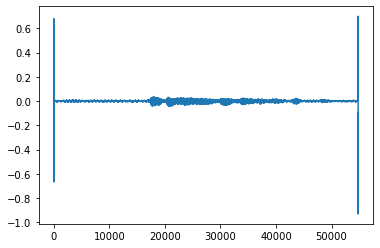

In [3]:
from pyhht.visualization import plot_imfs
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

path = 'D:\\result\\mixed_all_snr_STFT_1dx9_15epoch\\jiawei_T21-5_20200626_trains_passing1_snr2.wav' 
data , sr = librosa.load(path,sr=16000) 
# data = data/abs(data).max()
plt.plot(data)
# ipd.Audio(data,rate=16000) #播放